In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

In [5]:
# Device
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading
def load_data(data_dir, batch_size=64, img_size=224):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, test_loader

In [6]:
# FGSM attack
def fgsm_attack(model, criterion, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    grad = images.grad.data
    perturbed = images + epsilon * grad.sign()
    return torch.clamp(perturbed, 0, 1).detach()

# PGD attack
def pgd_attack(model, criterion, images, labels, epsilon, alpha, iters):
    ori_images = images.detach().clone()
    for _ in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, -epsilon, epsilon)
        images = torch.clamp(ori_images + eta, 0, 1).detach()
    return images

In [7]:
# Build and summary
def build_model(num_classes=2, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    in_feat = model.fc.in_features
    model.fc = nn.Linear(in_feat, num_classes)
    return model

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training loops
def train_clean(model, device, train_loader, optimizer, criterion, epochs=10):
    model.train()
    epoch_acc, epoch_loss = [], []
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        avg_loss = total_loss / len(train_loader)
        acc = correct / total
        epoch_loss.append(avg_loss)
        epoch_acc.append(acc)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} Acc: {acc*100:.2f}%")
    return epoch_acc, epoch_loss

def train_adversarial(model, device, train_loader, optimizer, criterion,
                      epochs=10, epsilon_fgsm=0.03, epsilon_pgd=0.03, alpha=0.01, pgd_iters=7):
    model.train()
    epoch_acc, epoch_loss = [], []
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            bs = images.size(0)
            idxs = torch.randperm(bs)
            n_fgsm = int(0.25 * bs)
            n_pgd = int(0.25 * bs)
            adv_images = images.clone()
            if n_fgsm > 0:
                adv_images[idxs[:n_fgsm]] = fgsm_attack(model, criterion,
                                                      images[idxs[:n_fgsm]], labels[idxs[:n_fgsm]], epsilon_fgsm)
            if n_pgd > 0:
                adv_images[idxs[n_fgsm:n_fgsm+n_pgd]] = pgd_attack(model, criterion,
                                                         images[idxs[n_fgsm:n_fgsm+n_pgd]],
                                                         labels[idxs[n_fgsm:n_fgsm+n_pgd]],
                                                         epsilon_pgd, alpha, pgd_iters)
            optimizer.zero_grad()
            outputs = model(adv_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        avg_loss = total_loss / len(train_loader)
        acc = correct / total
        epoch_loss.append(avg_loss)
        epoch_acc.append(acc)
        print(f"Adv Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} Acc: {acc*100:.2f}%")
    return epoch_acc, epoch_loss

In [8]:
# Evaluation and plotting
def evaluate(model, device, data_loader, attack=None, **atk_kwargs):
    model.eval()
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        if attack:
            # generate adversarial examples outside of no_grad
            adv_images = attack(model, criterion, images, labels, **atk_kwargs)
            with torch.no_grad():
                outputs = model(adv_images)
        else:
            with torch.no_grad():
                outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

def plot_training(acc1, acc2, loss1, loss2, epochs, save_path=None):
    # Accuracy
    plt.figure()
    plt.plot(range(1, epochs+1), acc1, label='Clean Train Acc')
    plt.plot(range(1, epochs+1), acc2, label='Adv Train Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')
    plt.legend()
    plt.tight_layout()
    if save_path: plt.savefig(save_path + '_acc.png')
    plt.show()
    # Loss
    plt.figure()
    plt.plot(range(1, epochs+1), loss1, label='Clean Train Loss')
    plt.plot(range(1, epochs+1), loss2, label='Adv Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.tight_layout()
    if save_path: plt.savefig(save_path + '_loss.png')
    plt.show()

def plot_results(results, save_path=None):
    plt.figure()
    plt.bar(results.keys(), results.values())
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_path: plt.savefig(save_path)
    plt.show()

Device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.9MB/s]



Baseline Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             R

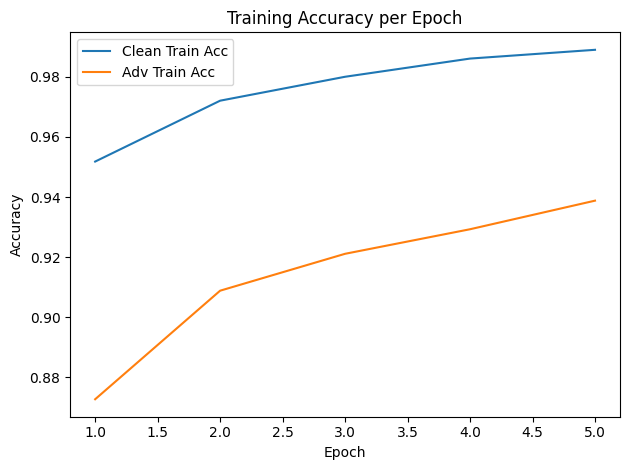

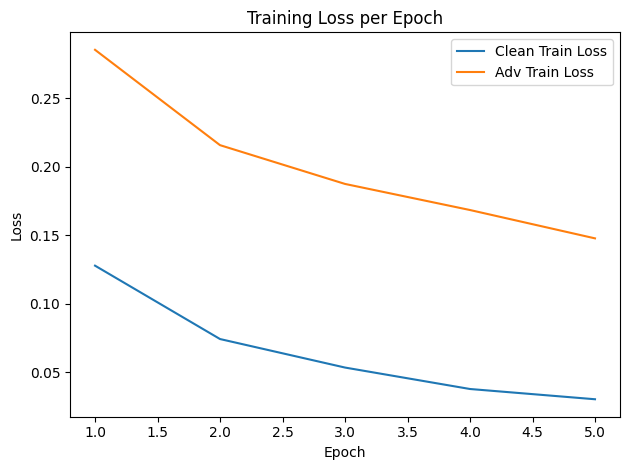

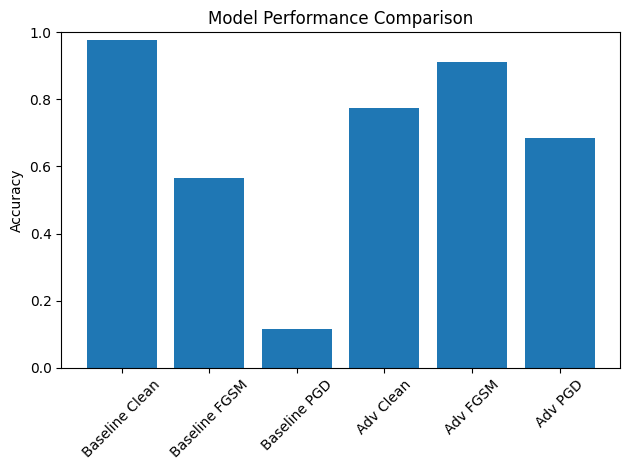

In [9]:
if __name__ == "__main__":
    data_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'
    epochs = 5
    batch_size = 32
    device = get_device()
    print(f"Device: {device}")

    train_loader, test_loader = load_data(data_dir, batch_size)

    # Baseline
    base_model = build_model().to(device)
    print("\nBaseline Model Summary:")
    summary(base_model, (3,224,224))
    print(f"Baseline Trainable Params: {count_params(base_model)}")
    optimizer = optim.Adam(base_model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    print("\nTraining Baseline on clean data...")
    base_acc, base_loss = train_clean(base_model, device, train_loader, optimizer, criterion, epochs)

    # Adversarial
    adv_model = build_model().to(device)
    print("\nAdversarial Model Summary:")
    summary(adv_model, (3,224,224))
    print(f"Adv Trainable Params: {count_params(adv_model)}")
    adv_optimizer = optim.Adam(adv_model.parameters(), lr=1e-4)
    print("\nTraining Adversarial Model on mixed data...")
    adv_acc, adv_loss = train_adversarial(adv_model, device, train_loader, adv_optimizer, criterion, epochs)

    # Evaluate
    print("\nEvaluating Models on Test Set...")
    results = {
        'Baseline Clean': evaluate(base_model, device, test_loader),
        'Baseline FGSM': evaluate(base_model, device, test_loader, attack=fgsm_attack, epsilon=0.05),
        'Baseline PGD': evaluate(base_model, device, test_loader, attack=pgd_attack, epsilon=0.03, alpha=0.01, iters=7),
        'Adv Clean': evaluate(adv_model, device, test_loader),
        'Adv FGSM': evaluate(adv_model, device, test_loader, attack=fgsm_attack, epsilon=0.05),
        'Adv PGD': evaluate(adv_model, device, test_loader, attack=pgd_attack, epsilon=0.03, alpha=0.01, iters=7)
    }

    # Print final metrics
    print("\nFinal Accuracies and Training Acc:")
    print(f"Baseline Final Train Acc: {base_acc[-1]*100:.2f}% | Final Train Loss: {base_loss[-1]:.4f}")
    for k, v in results.items(): print(f"{k}: {v*100:.2f}%")

    # Plots
    plot_training(base_acc, adv_acc, base_loss, adv_loss, epochs, save_path='train_metrics')
    plot_results(results, save_path='test_comparison')
